# Imports

In [49]:
import os

# import plotting libraries
from matplotlib import pyplot as plt
import seaborn as sns
import math

# import machine learning libraries
import tensorflow as tf 
import tensorflow_io as tfio
from tensorflow import keras 
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout, GlobalAveragePooling2D, Activation
from tensorflow.keras import Sequential

#import audio processing libraries
from scipy.io.wavfile import write
from scipy.io.wavfile import read
import librosa.display
import librosa
from IPython.display import Audio

#import data processing libraries
from string import ascii_uppercase
from pandas import DataFrame
import itertools
import numpy as np

#import machine learning metrics
from sklearn.metrics import confusion_matrix

# Constants

In [5]:
SNORING_PATH = os.path.join('dataset', 'snoring')
NO_SNORING_PATH = os.path.join('dataset', 'nosnoring')

# sample files
SNORING_FILE = os.path.join(SNORING_PATH, '1_0.wav')
NO_SNORING_FILE = os.path.join(NO_SNORING_PATH, '0_0.wav')

# Helper Functions

In [6]:
def resample(waveform, sample_rate):
    waveform = waveform.numpy()
    sample_rate = sample_rate.numpy()
    return librosa.resample(waveform, orig_sr=sample_rate, target_sr=16000)

# Loads an audio file and converts it from 44KHz to 16KHz
def load_audio(filename):
    # if tf.is_tensor(filename):
    #     filename = filename.numpy().decode('utf-8')
    audio = tf.io.read_file(filename)
    waveform, sample_rate = tf.audio.decode_wav(audio, desired_channels=1)
    # removes trailing silence in audio
    waveform = tf.squeeze(waveform, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # # convert the TensorFlow tensor to a numpy array
    # waveform_np = waveform.numpy()
    # # resamples the audio to 16KHz
    # waveform = librosa.resample(np.float32(waveform_np), orig_sr=sample_rate.numpy(), target_sr=16000)
    waveform = tf.py_function(resample, [waveform, sample_rate], tf.float32)
    return waveform


# converts symbolic tensors to concrete tensors
def load_audio_wrapper(filename, label):
    waveform = load_audio(filename)
    return waveform, label

# Verify the Data

In [7]:
snoring16k = load_audio(SNORING_FILE)
no_snoring16k = load_audio(NO_SNORING_FILE)

C:\Users\janon\AppData\Local\Temp\ipykernel_28544\715192526.py:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  input_audio = read(SNORING_FILE)


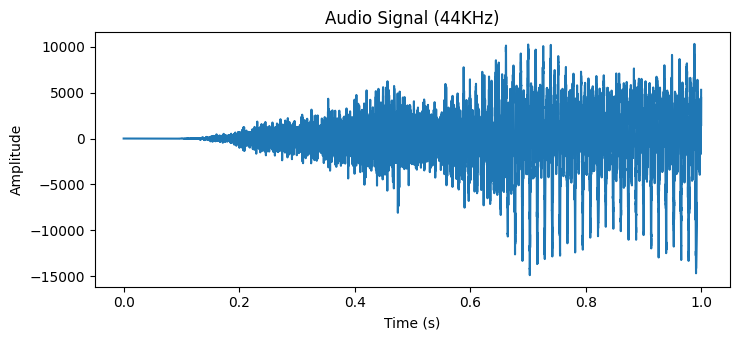

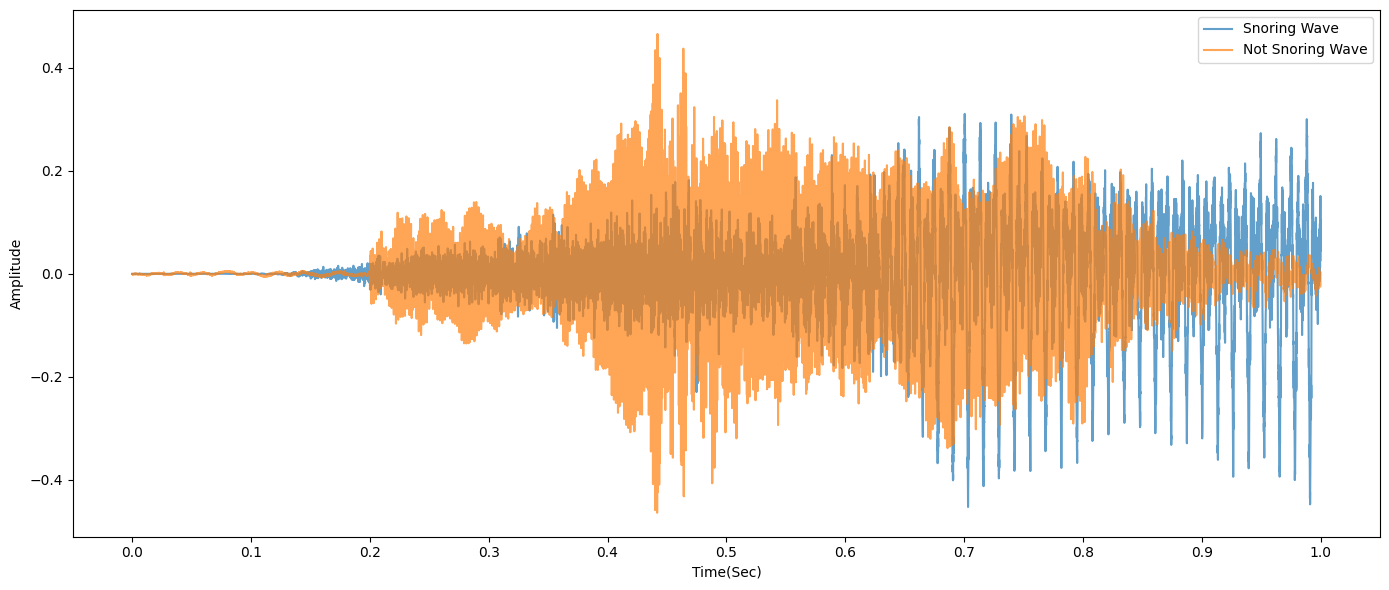

In [8]:
# plot audio file as 44KHz
plt.rcParams['figure.figsize'] = (7.5, 3.5)
plt.rcParams['figure.autolayout'] = True
input_audio = read(SNORING_FILE)
x = np.linspace(0, 1, num=len(input_audio[1]))

audio = input_audio[1]
plt.plot(x, audio)
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')
plt.title('Audio Signal (44KHz)')
plt.show()

# plot snoring and no-snoring audio file as 16KHz
x = np.linspace(0, 1, 16000)
plt.figure(figsize=(14, 6))
plt.plot(x,snoring16k, alpha=0.7)
plt.plot(x,no_snoring16k, alpha=0.7)
plt.xlabel('Time(Sec)')
plt.ylabel('Amplitude')
plt.legend(labels=['Snoring Wave', 'Not Snoring Wave'])
plt.xticks(np.linspace(0, 1, 11))
plt.show()

# Load Dataset

In [9]:
snoring_set = tf.data.Dataset.list_files(SNORING_PATH + '/*.wav')
no_snoring_set = tf.data.Dataset.list_files(NO_SNORING_PATH + '/*.wav')

# create labels for the dataset; 1 for snoring and 0 for no snoring
positives = tf.data.Dataset.zip((snoring_set, tf.data.Dataset.from_tensor_slices(tf.ones(len(snoring_set)))))
negatives = tf.data.Dataset.zip((no_snoring_set, tf.data.Dataset.from_tensor_slices(tf.zeros(len(no_snoring_set)))))
dataset = positives.concatenate(negatives)

# obtains the lengths of the audio files
lengths = []
for file in os.listdir(os.path.join(NO_SNORING_PATH)):
    tensor_wave = load_audio(os.path.join(NO_SNORING_PATH, file))
    lengths.append(len(tensor_wave))

# obtain the mean, min and max lengths of the audio files
# this value must be 16000 to ensure all audio files are the same length
tf.math.reduce_mean(lengths)
tf.math.reduce_min(lengths)
tf.math.reduce_max(lengths)


<tf.Tensor: shape=(), dtype=int32, numpy=16000>

In [10]:
# preprocesses the audio
def preprocessing(waveform, label):
    # takes only the first 16000 samples
    audio = waveform[:16000]
    # pads audio shorter than 16000 samples
    padding = tf.zeros([16000] - tf.shape(audio), dtype=tf.float32)
    audio = tf.concat([padding, audio], 0)
    # obtains the short-time Fourier transform of the audio
    spectrogram = tf.signal.stft(audio, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    # adds an extra dimension to the spectrogram
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

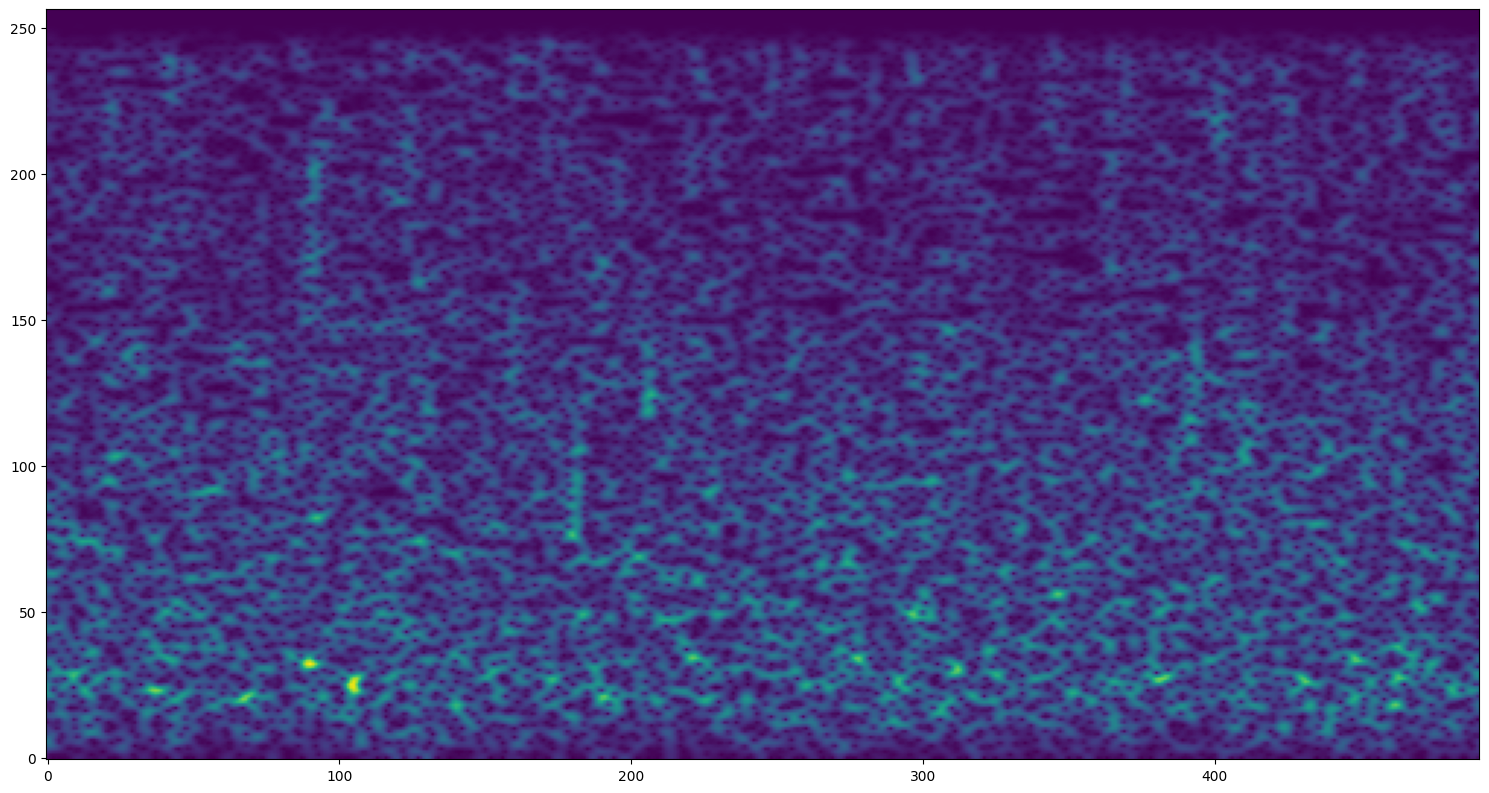

In [11]:
# shuffles the negatives dataset and load them into memory
filename, label = negatives.shuffle(buffer_size=10000).as_numpy_iterator().next()

# load the audio from the filename
waveform, label = load_audio_wrapper(filename, label)

# test the preprocessing function and plot the spectrogram
spectrogram, label = preprocessing(waveform, label)

plt.figure(figsize=(15, 8))
plt.imshow(tf.transpose(spectrogram)[0])
plt.gca().invert_yaxis()
plt.show()

In [12]:
dataset.as_numpy_iterator().next()

dataset = dataset.map(load_audio_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.map(preprocessing, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.cache()
dataset = dataset.shuffle(1000)
dataset = dataset.batch(64)
dataset = dataset.prefetch(tf.data.AUTOTUNE)

In [13]:
# calculates the size of the dataset for splitting into 70% training and 30% validation
total_size = len(list(dataset))
train_size = int(0.7 * total_size)
val_size = total_size - train_size

# shuffle the dataset before splitting
dataset = dataset.shuffle(total_size)

# split the dataset
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

# obtain the shape of the first batch of the training dataset
samples, labels = train_dataset.as_numpy_iterator().next()
samples.shape

input_shape = samples.shape[1:]

# Model Architecture

In [27]:
model = Sequential()                                                          # create a sequential model
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=input_shape))     # add a convolutional layer
model.add(Conv2D(16, (3, 3), activation='relu'))                              # add another convolutional layer
model.add(Flatten())                                                          # flatten the output
model.add(Dense(128, activation='relu'))                                      # add a dense layer               
model.add(Dense(1, activation='sigmoid'))                                     # add the output layer

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()]) 

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 489, 255, 16)      160       
                                                                 
 conv2d_1 (Conv2D)           (None, 487, 253, 16)      2320      
                                                                 
 flatten (Flatten)           (None, 1971376)           0         
                                                                 
 dense (Dense)               (None, 128)               252336256 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 252338865 (962.60 MB)
Trainable params: 252338865 (962.60 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
hist = model.fit(train_dataset, validation_data=val_dataset, epochs=10)

Epoch 1/10

11/11 [==============================] - 162s 10s/step - loss: 19.4591 - recall_1: 0.5360 - precision_1: 0.5924 - val_loss: 4.5446 - val_recall_1: 0.7572 - val_precision_1: 0.6453
Epoch 2/10
11/11 [==============================] - 81s 7s/step - loss: 1.5876 - recall_1: 0.6142 - precision_1: 0.7500 - val_loss: 0.3995 - val_recall_1: 0.8580 - val_precision_1: 0.8129
Epoch 3/10
11/11 [==============================] - 77s 7s/step - loss: 0.3515 - recall_1: 0.8794 - precision_1: 0.8081 - val_loss: 0.2469 - val_recall_1: 0.8961 - val_precision_1: 0.9452
Epoch 4/10
11/11 [==============================] - 64s 6s/step - loss: 0.2456 - recall_1: 0.9454 - precision_1: 0.9320 - val_loss: 0.1552 - val_recall_1: 0.9733 - val_precision_1: 0.9865
Epoch 5/10
11/11 [==============================] - 61s 6s/step - loss: 0.1466 - recall_1: 0.9634 - precision_1: 0.9942 - val_loss: 0.1227 - val_recall_1: 0.9874 - val_precision_1: 0.9691
Epoch 6/10
11/11 [==============================] - 59s 

# Model Results

In [34]:
# plot legends
loss = 'loss'
val_loss = 'val_loss'
recall = 'recall_1'
val_recall = 'val_recall_1'
precision = 'precision_1'
val_precision = 'val_precision_1'

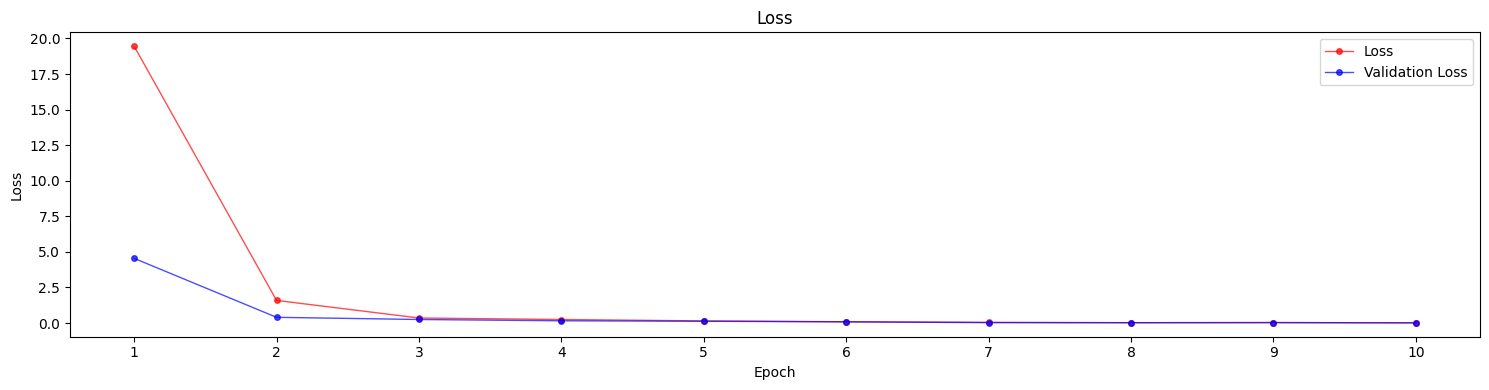

In [35]:
# loss per epoch
x_values = np.arange(1,11,1)
fig, ax = plt.subplots()
plt.rcParams['figure.figsize'] = (15,4)

plt.title('Loss')
plt.plot(x_values,hist.history[loss], 'r',marker='o', linewidth=1,alpha=0.7,label = 'Loss',markersize=4)
plt.plot(x_values,hist.history[val_loss], 'b',marker='o', linewidth=1,alpha=0.7,label = 'Validation Loss',markersize=4)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.xticks(x_values)
x = x_values
y = hist.history[loss]
z = hist.history[loss]
val_z = hist.history[val_loss]
i=0
for X, Y, Z,VAL_Z in zip(x, y, z,val_z):
    if i==14:
        # Annotate the points 5 _points_ above and to the left of the vertex
        ax.annotate('Loss = {}'.format(round(Z,5)), xy=(X,Y), xytext=(-5, 25), ha='center',
                    textcoords='offset points')
        ax.annotate('Val. Loss = {}'.format(round(VAL_Z,5)), xy=(X,Y), xytext=(-5, 15), ha='center',
                    textcoords='offset points')
    i=i+1 
plt.show()

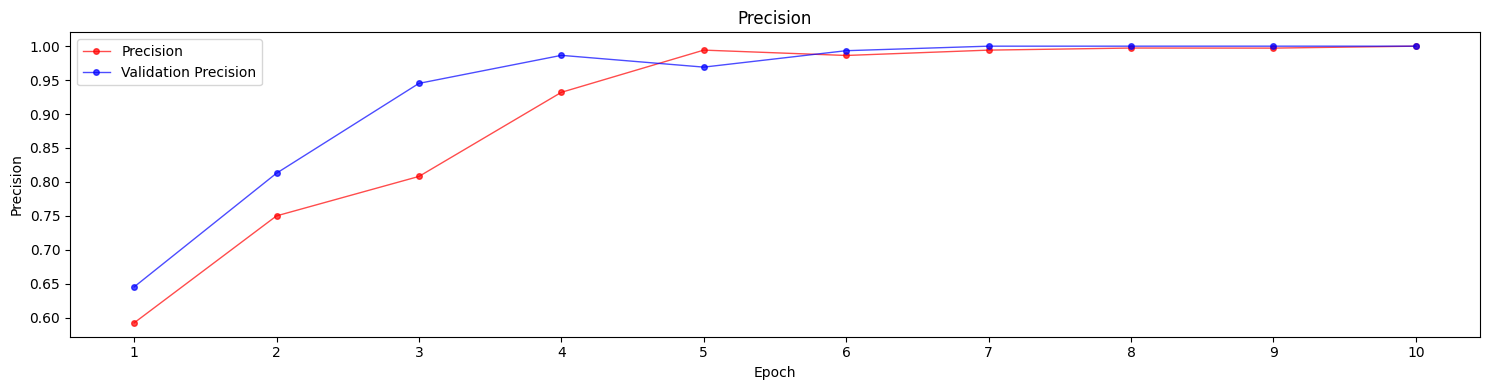

In [36]:
# precision per epoch
fig, ax = plt.subplots()
plt.rcParams['figure.figsize'] = (15,3)

plt.title('Precision')
plt.plot(x_values,hist.history[precision], 'r',marker='o', linewidth=1,alpha=0.7,label = 'Precision',markersize=4)
plt.plot(x_values,hist.history[val_precision], 'b',marker='o', linewidth=1,alpha=0.7,label = 'Validation Precision',markersize=4)
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.xticks(x_values)
x = x_values
y = hist.history[precision]
z = hist.history[precision]
val_z = hist.history[val_precision]
i=0
for X, Y, Z,VAL_Z in zip(x, y, z,val_z):
    if i==14:
        # Annotate the points 5 _points_ above and to the left of the vertex
        ax.annotate('Prec. = {}'.format(round(Z,5)), xy=(X,Y), xytext=(-0, -15), ha='center',
                    textcoords='offset points')
        ax.annotate('Val. Prec. = {}'.format(round(VAL_Z,5)), xy=(X,Y), xytext=(-0, -25), ha='center',
                    textcoords='offset points')
    i=i+1 
plt.show()

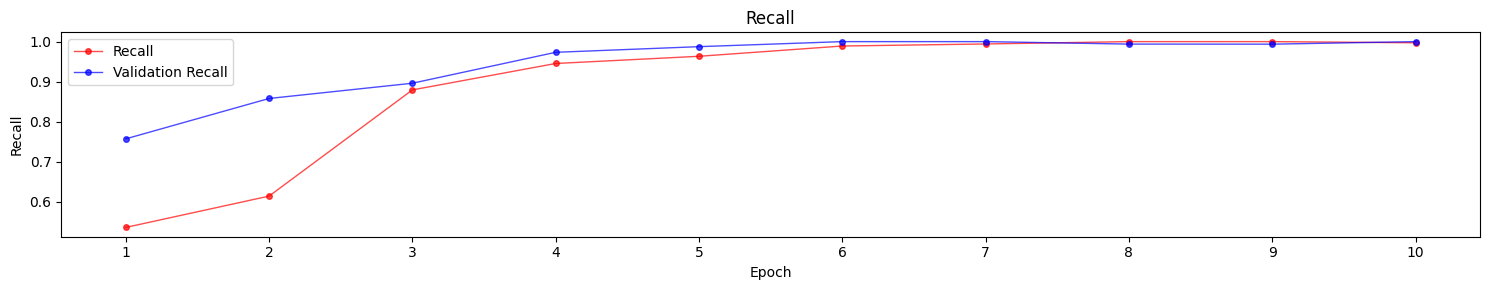

In [37]:
# recall per epoch

fig, ax = plt.subplots()
plt.rcParams['figure.figsize'] = (15,4)

plt.title('Recall')
ax.plot(x_values,hist.history[recall], 'r',marker='o', linewidth=1,alpha=0.7,label = 'Recall',markersize=4)
ax.plot(x_values,hist.history[val_recall], 'b',marker='o', linewidth=1,alpha=0.7,label = 'Validation Recall',markersize=4)
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.xticks(x_values)
x = x_values
y = hist.history[recall]
z = hist.history[recall]
val_z = hist.history[val_recall]
i=0
for X, Y, Z,VAL_Z in zip(x, y, z,val_z):
    if i==14:
        # Annotate the points 5 _points_ above and to the left of the vertex
        ax.annotate('Recall = {}'.format(round(Z,5)), xy=(X,Y), xytext=(-0, -15), ha='center',
                    textcoords='offset points')
        ax.annotate('Val. Recall = {}'.format(round(VAL_Z,5)), xy=(X,Y), xytext=(-0, -25), ha='center',
                    textcoords='offset points')
    i=i+1    
plt.show()

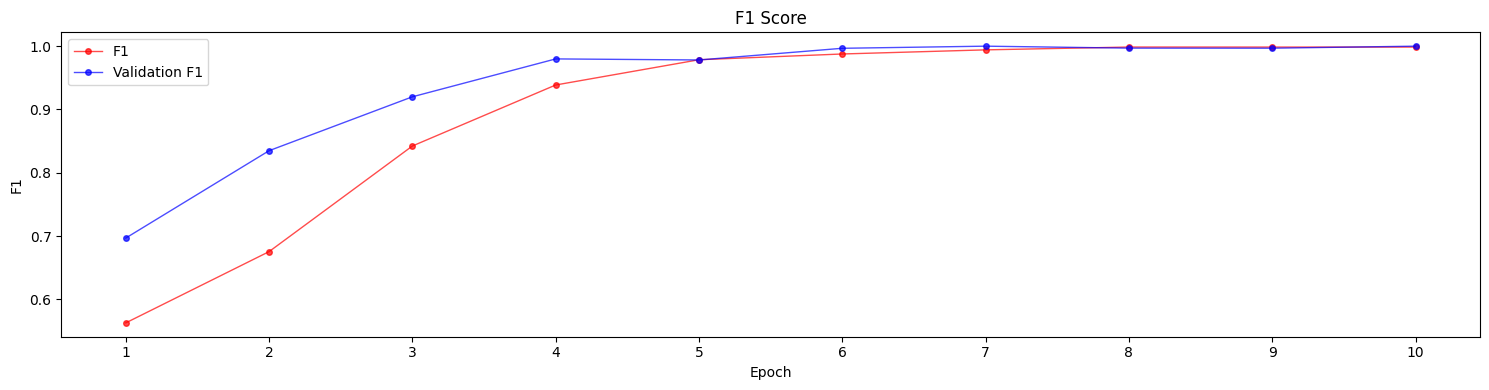

In [38]:
# f1 score per epoch
fig, ax = plt.subplots()

f1 = []
val_f1 = []
for i in range (0,len(hist.history[recall])):
    f1.append(2 * (hist.history[recall][i] * hist.history[precision][i]) / 
              (hist.history[recall][i] + hist.history[precision][i]))
    val_f1.append(2 * (hist.history[val_recall][i] * hist.history[val_precision][i]) / 
              (hist.history[val_recall][i] + hist.history[val_precision][i]))
plt.rcParams['figure.figsize'] = (14,4)

plt.title('F1 Score')
ax.plot(x_values,f1, 'r',marker='o', linewidth=1,alpha=0.7,label = 'F1',markersize=4)
ax.plot(x_values,val_f1, 'b',marker='o', linewidth=1,alpha=0.7,label = 'Validation F1',markersize=4)
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.legend()
plt.xticks(x_values)
x = x_values
y = f1
z = f1
val_z = val_f1
i=0
for X, Y, Z,VAL_Z in zip(x, y, z,val_z):
    if i==14:
        # Annotate the points 5 _points_ above and to the left of the vertex
        ax.annotate('F1 = {}'.format(round(Z,5)), xy=(X,Y), xytext=(-0, -15), ha='center',
                    textcoords='offset points')
        ax.annotate('Val. F1 = {}'.format(round(VAL_Z,5)), xy=(X,Y), xytext=(-0, -25), ha='center',
                    textcoords='offset points')
    i=i+1 
plt.show() 

# Save Model

In [39]:
model_name = 'snore_detector.h5'
tf.keras.models.save_model(model, './saved_models/' + model_name)

C:\Users\janon\AppData\Local\Temp\ipykernel_28544\200058282.py:2: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model, './saved_models/' + model_name)


In [40]:
# test loading the model
snore_detector = tf.keras.models.load_model('./saved_models/' + model_name)
model = snore_detector

# Model testing

2/2 [==============================] - 1s 380ms/step


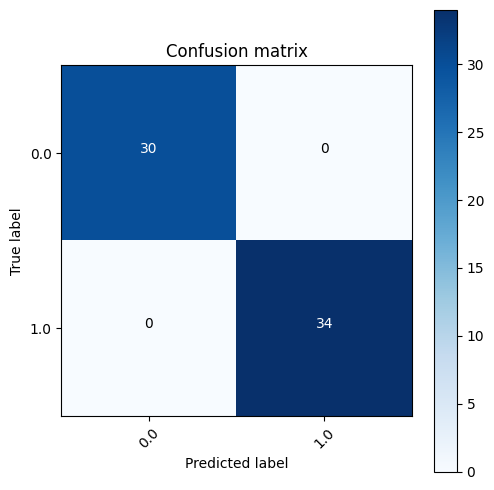

In [51]:
Xtest, ytest = val_dataset.as_numpy_iterator().next()
xtest = model.predict(Xtest)
xtest = [1 if prediction > 0.5 else 0 for prediction in xtest]
ytest.astype(int)

classes = list(np.unique(ytest))

# compue confusion matrix
cm = confusion_matrix(ytest.astype(int), xtest)

# Plot confusion matrix
plt.figure(figsize=(5, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()